In [18]:
import torch
import higher
from torch import nn, autograd as ag
import matplotlib.pyplot as plt
import numpy as np
import pyccl as ccl
import scipy
import tqdm
import os
import copy
import argparse
import models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

## Start with a simple scenario where we train on fixed sources

In [19]:
n_samples = 50

Omega_b_arr = np.linspace(0.04, 0.06, n_samples)
Omega_c_arr = np.linspace(0.25, 0.35, n_samples)
h_arr = np.linspace(0.6, 0.8, n_samples)
sigma8_arr = np.linspace(0.7, 0.9, n_samples)
n_s_arr = np.linspace(0.9, 1.1, n_samples)

z= np.linspace(0., 3., 256)
z0 = 0.1
dndz = 1./(2.*z0) * (z / z0)**2 * np.exp(-z/z0)

l_arr = np.unique(np.geomspace(2, 60000, 30).astype(int))

if os.path.isfile('Cgg_data.npz'):
    data = np.load('Cgg_data.npz')
    Cgg_data = data['Cgg_data']
    l_arr = data['l_arr']
    Omega_b_arr = data['Omega_b_arr']
    Omega_c_arr = data['Omega_c_arr']
    h_arr = data['h_arr']
    sigma8_arr = data['sigma8_arr']
    n_s_arr = data['n_s_arr']
else:
    Cgg_data = np.zeros((n_samples, len(l_arr)))
    for i in tqdm.trange(n_samples):
        cosmo = ccl.Cosmology(Omega_c=Omega_c_arr[i], Omega_b=Omega_b_arr[i],
                            h=h_arr[i], sigma8=sigma8_arr[i], n_s=n_s_arr[i])
        lensTracer = ccl.WeakLensingTracer(cosmo, dndz=(z, dndz))
        Cgg_data[i,:] = ccl.angular_cl(cosmo, lensTracer, lensTracer, l_arr)
        plt.loglog(l_arr, Cgg_data[i,:])

    np.savez('Cgg_data.npz', Cgg_data=Cgg_data, l_arr=l_arr, Omega_b_arr=Omega_b_arr,
                Omega_c_arr=Omega_c_arr, h_arr=h_arr, sigma8_arr=sigma8_arr, n_s_arr=n_s_arr)

In [20]:
model = nn.Sequential(
    nn.Linear(5, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, len(l_arr))
)
    
# collate training data
X = np.vstack((Omega_b_arr, Omega_c_arr, h_arr, sigma8_arr, n_s_arr)).T
y = Cgg_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# standardize data
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)

# create dataloader
batch_size = 512

# define loss function
loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

CosStandard = models.CosMAML(model)
losses = CosStandard.train(X_train, y_train, 1000, 32, optimiser, loss_fn)

Text(0, 0.5, 'Loss')

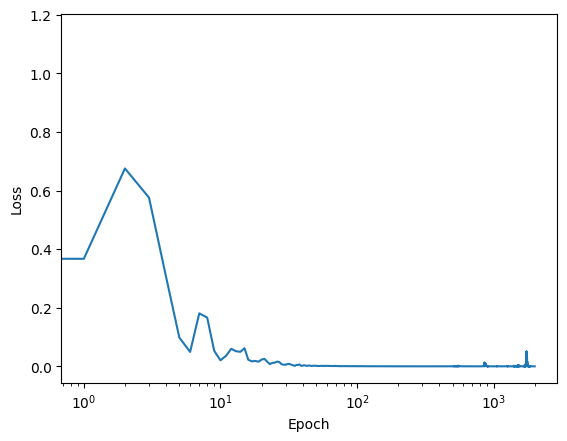

In [21]:
plt.plot(losses)
plt.xscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')

(10, 29)


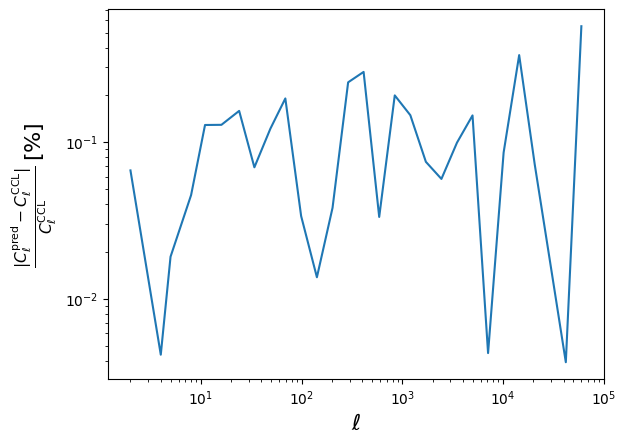

In [22]:
pred = CosStandard.predict(X_test)
print(pred.shape)
pred = scaler_y.inverse_transform(pred)
plt.figure()
i = 0
plt.loglog(l_arr, (abs(pred[i]-y_test[i])/y_test[i] * 100), label='Predicted', ls='-')
plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'$\frac{|C_{\ell}^{\rm pred} - C_{\ell}^{\rm CCL}|}{C_{\ell}^{\rm CCL}} \, [\%]$', fontsize=16)
plt.savefig('Cgg_pred_bias.png', bbox_inches='tight')

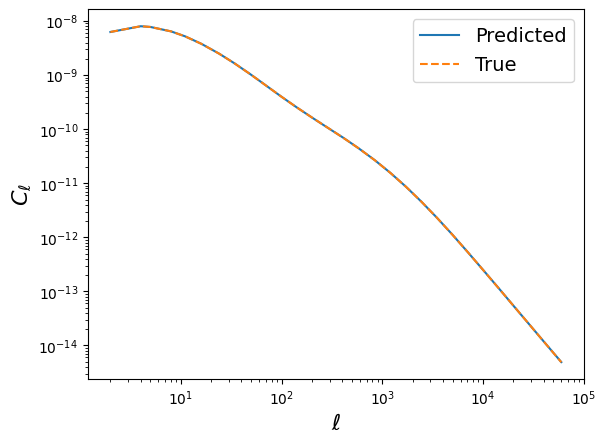

In [23]:
plt.loglog(l_arr, pred[i], label='Predicted', ls='-')
plt.loglog(l_arr, y_test[i], label='True', ls='--')
plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'$C_{\ell}$', fontsize=16)
plt.legend(fontsize=14)
plt.savefig('Cgg_pred.png', bbox_inches='tight')

Clearly the model cannot accurately predict the C_ell for a different redshift distribution

## Try use MAML to allow for different source distributiuons to be used

In [48]:
kwd = 'large'

if kwd == 'small':
    if os.path.isfile('Cgg_data.npz'):
        with np.load('Cgg_data.npz') as data:
            C_ells = data['Cgg_data']
            l_arr = data['l_arr']
            Omega_b_arr = data['Omega_b_arr']
            Omega_c_arr = data['Omega_c_arr']
            h_arr = data['h_arr']
            sigma8_arr = data['sigma8_arr']
            n_s_arr = data['n_s_arr']
elif kwd == 'large':
    if os.path.isfile('Cgg_data_multi_task.npz'):
        with np.load('Cgg_data_multi_task.npz') as data:
            C_ells = data['C_ells']
            l_arr = data['l_arr']
            Omega_b_arr = data['Omega_b_arr']
            Omega_c_arr = data['Omega_c_arr']
            h_arr = data['h_arr']
            sigma8_arr = data['sigma8_arr']
            n_s_arr = data['n_s_arr']
            z0_arr = datba['z0']
            dndz = data['dndz']
else:
    print('Training data file not found')

n_tasks = np.shape(C_ells)[0]
n_samples = np.shape(C_ells)[1]
print(n_tasks, n_samples)

200 50


In [ ]:
CosyStan = 

C_ell data
- Rows are different samples.
- Columns are different tasks. 

(50, 5)
[43 24 12 22  7 38]


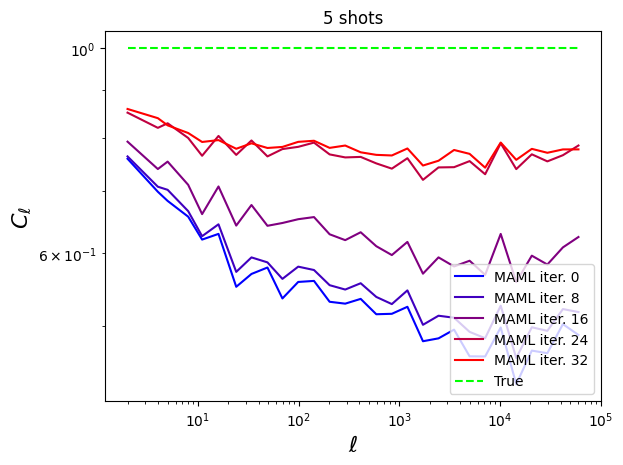

-----------------------------
iteration  10
loss 0.29800308232920125


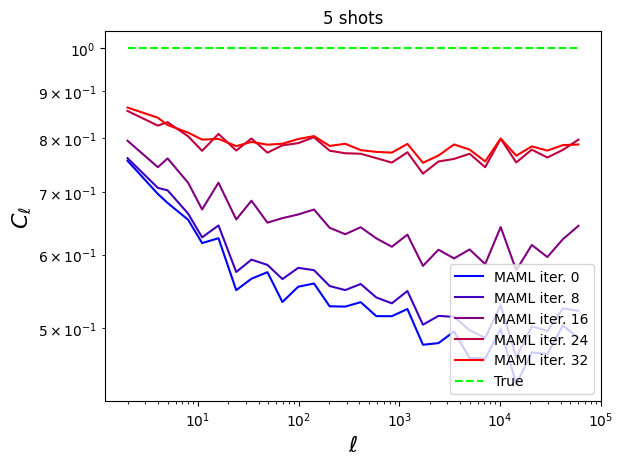

-----------------------------
iteration  20
loss 0.31175718569314453


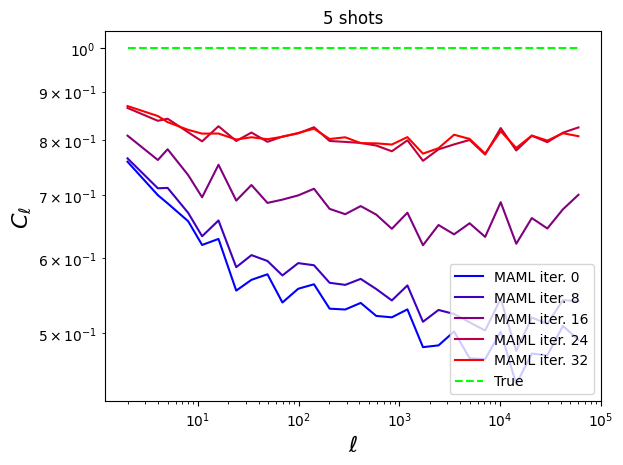

-----------------------------
iteration  30
loss 0.33216519006994705


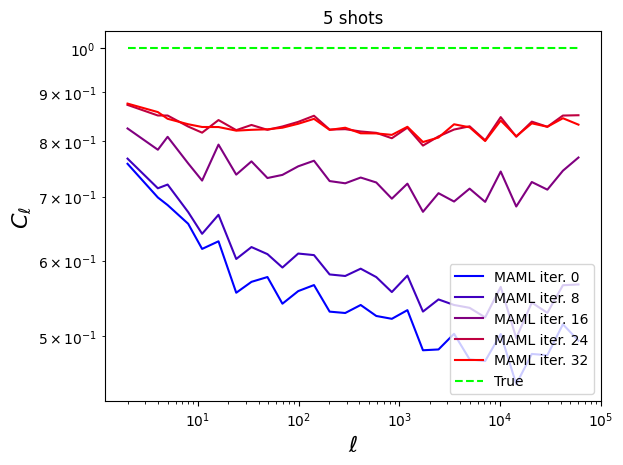

-----------------------------
iteration  40
loss 0.3614800968063736


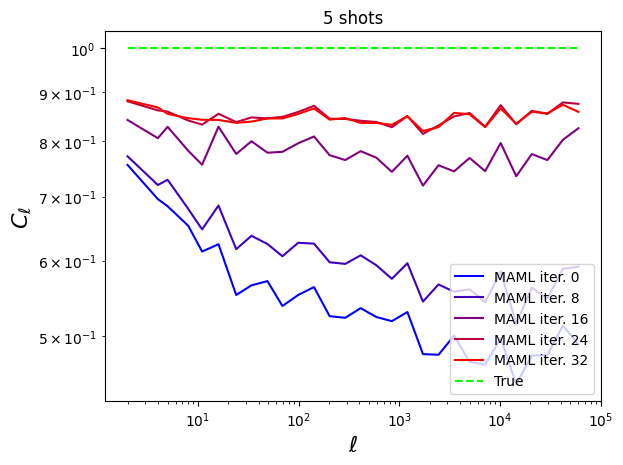

-----------------------------
iteration  50
loss 0.39710811621993525


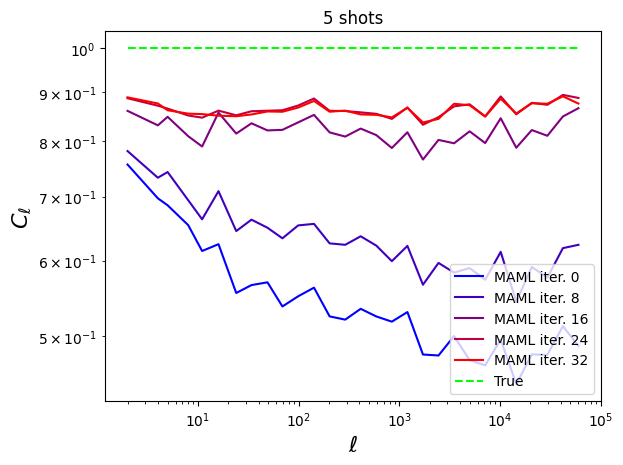

-----------------------------
iteration  60
loss 0.43966422922593934


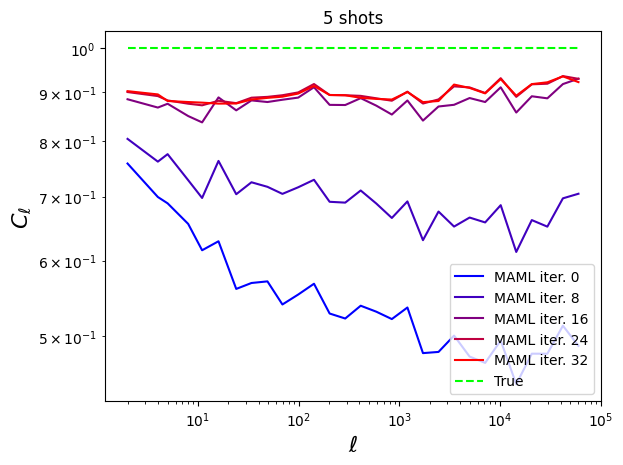

-----------------------------
iteration  70
loss 0.5262192502753545


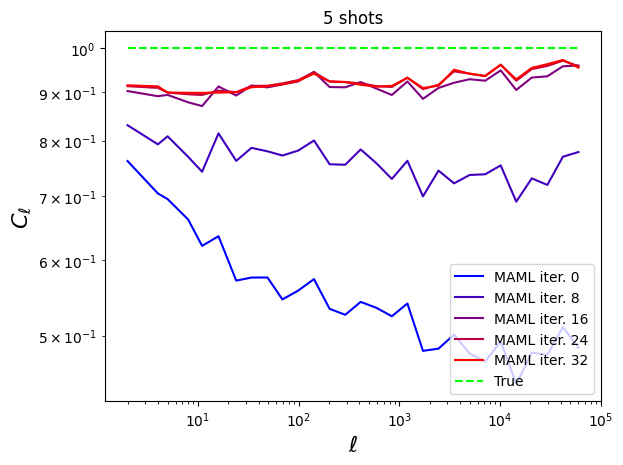

-----------------------------
iteration  80
loss 0.6162957682965164


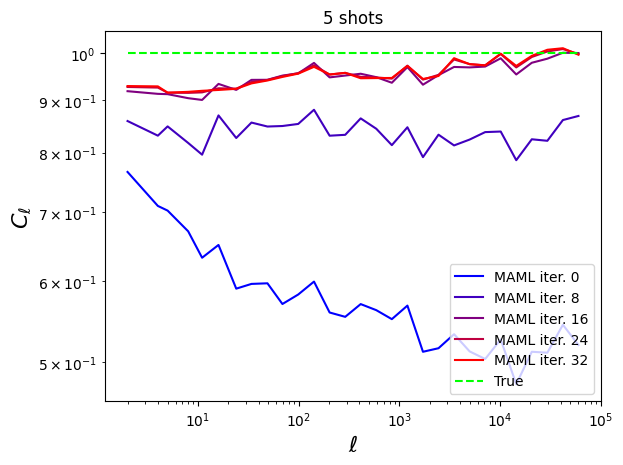

-----------------------------
iteration  90
loss 0.7177683830978555


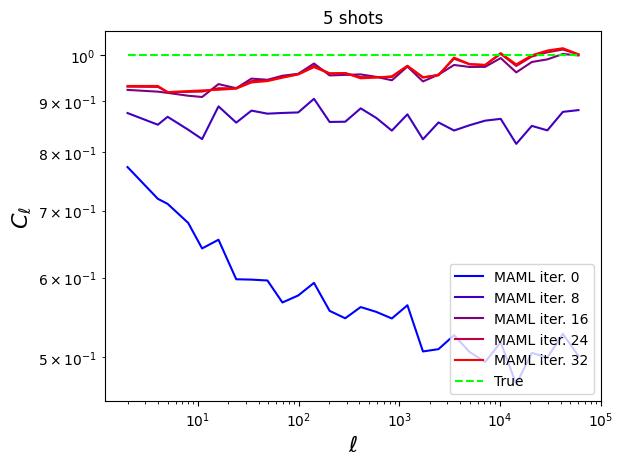

-----------------------------
iteration  100
loss 0.76347319675159


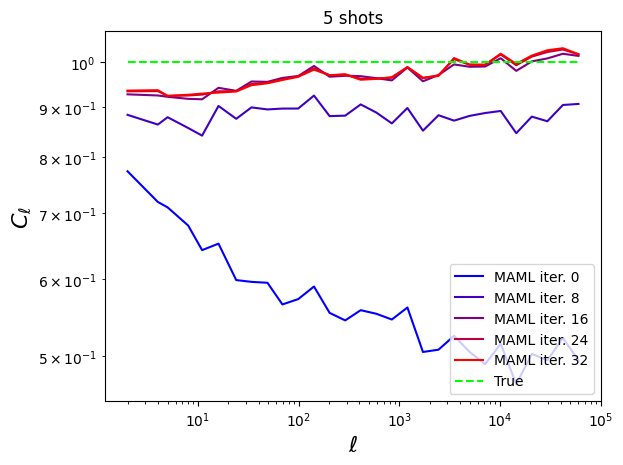

-----------------------------
iteration  110
loss 0.8045671639954651


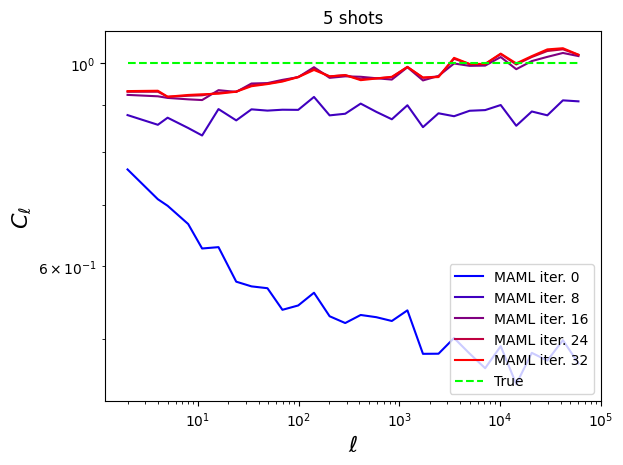

-----------------------------
iteration  120
loss 0.8042934793681493


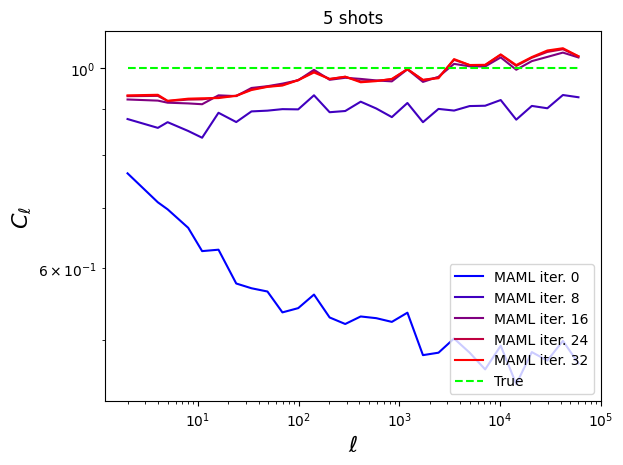

-----------------------------
iteration  130
loss 0.8238704684969312


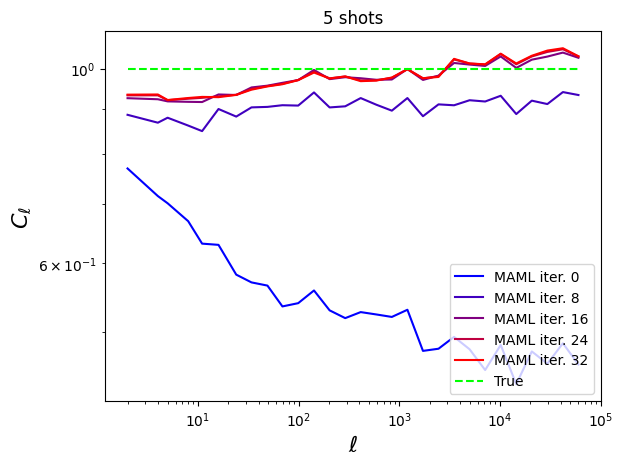

-----------------------------
iteration  140
loss 0.8430593772122186


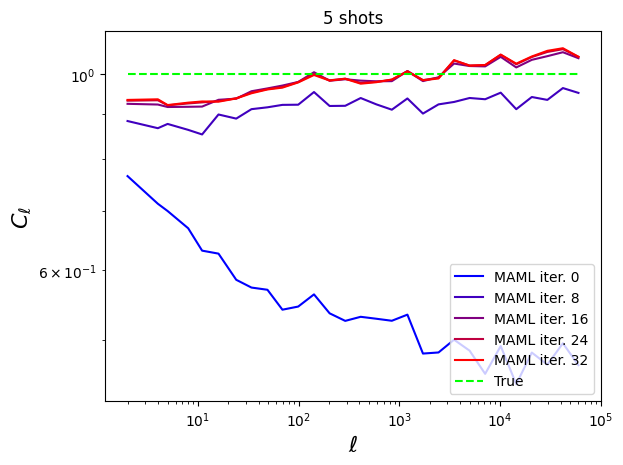

-----------------------------
iteration  150
loss 0.8601042061176027


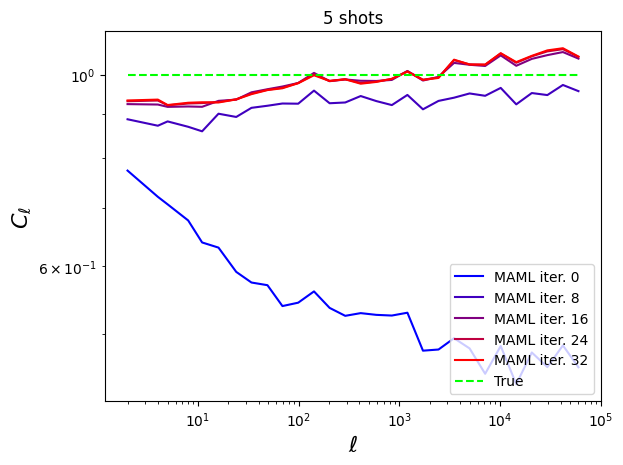

-----------------------------
iteration  160
loss 0.8746409435791586


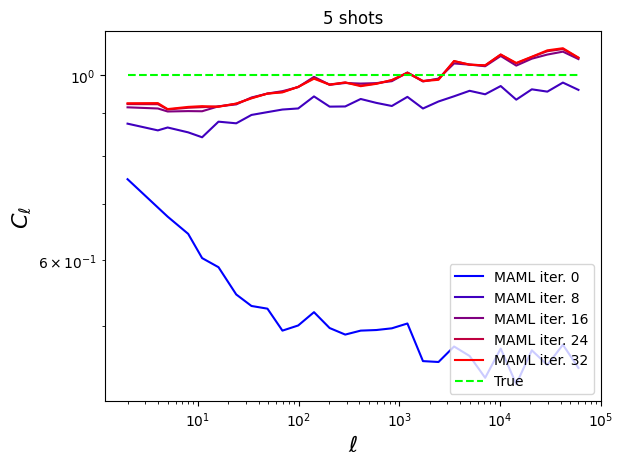

-----------------------------
iteration  170
loss 0.8669043875161657


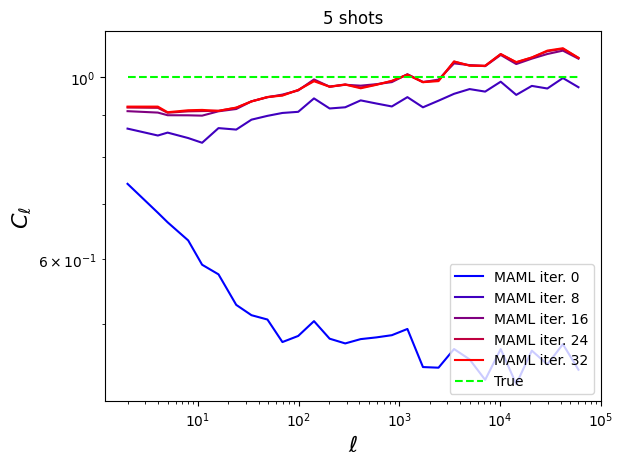

-----------------------------
iteration  180
loss 0.8670796882252426


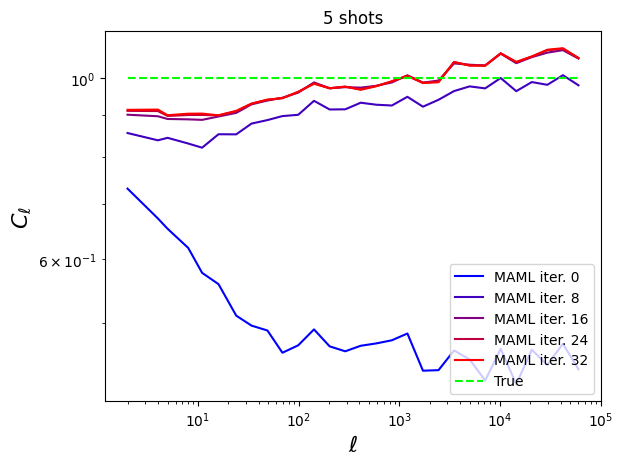

-----------------------------
iteration  190
loss 0.8704624620912443


In [54]:
seed = 14
rng = np.random.RandomState(seed)
torch.manual_seed(seed)

CosmEmbryo = nn.Sequential(
    nn.Linear(5, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, len(l_arr))
)

# collate training data
scaler_x = StandardScaler()
X_all = np.vstack((Omega_b_arr, Omega_c_arr, h_arr, sigma8_arr, n_s_arr)).T
X_all = scaler_x.fit_transform(X_all)
print(X_all.shape)
# send model to GPU
CosmEmbryo.to('cuda')

inner_epochs = 1
batch_size = 5

weight_decay = 1e-4
inner_step_size = 0.1
outer_step_size = 0.02
loss_fn = nn.MSELoss() # loss function

def to_torch(x):
    return ag.Variable(torch.tensor(x, dtype=torch.float32).to('cuda'))

def train_on_batch(x, y):
    x = to_torch(x)
    y = to_torch(y)
    CosmEmbryo.zero_grad()
    pred = CosmEmbryo(x)
    loss = loss_fn(pred, y)
    loss.backward()
    for param in CosmEmbryo.parameters():
        param.data -= inner_step_size * param.grad.data

def predict(x):
    x = to_torch(x)
    return CosmEmbryo(x).detach().cpu().numpy()

# Generate new task to test on
rand_inds = rng.choice(n_samples, size=batch_size+1)
print(rand_inds)
xtrain_plot = X_all[rand_inds[:-1],:]

task_plot = 0
y_plot = C_ells[rand_inds[:-1],task_plot,:]
scaler_plot = StandardScaler()
y_plot = scaler_plot.fit_transform(y_plot)

# Training loop
# Outer loop trains on different tasks
for task in range(n_tasks):
    if task == task_plot:
        continue
    weights_before = copy.deepcopy(CosmEmbryo.state_dict())

    inds = rng.permutation(n_samples)
    train_inds = inds[:-1*batch_size]
    test_inds = inds[-1*batch_size:]
    y_all = C_ells[task] # all samples for this task
    scaler_y = StandardScaler()
    y_all = scaler_y.fit_transform(y_all)

    # Inner loop trains on different inputs for the same task
    for _ in range(inner_epochs):
        for start in range(0, len(train_inds), batch_size):
            batch_inds = train_inds[start:start+batch_size]
            train_on_batch(X_all[batch_inds,:], y_all[batch_inds,:])
            
    outer_step_schedule = outer_step_size * (1.0 - task / n_tasks) # linear schedule
    for start in range (0, len(test_inds), batch_size):
        batch_inds = test_inds[start:start+batch_size]
        x = to_torch(X_all[batch_inds,:])
        y = to_torch(y_all[batch_inds,:])

        # Compute grads
        CosmEmbryo.zero_grad()
        pred = CosmEmbryo(x)
        loss = loss_fn(pred, y)
        loss.backward()

        # Reload weights from before training
        CosmEmbryo.load_state_dict(weights_before)

        # SGD on the params
        for param in CosmEmbryo.parameters():
            param.data -= outer_step_size * param.grad.data

    if task % 10 == 0:
        plt.cla()
        plt.title(f'%d shots'%batch_size)
        weights_before = copy.deepcopy(CosmEmbryo.state_dict())
        y_pred_init = predict(X_all)
        y_pred_init = scaler_plot.inverse_transform(y_pred_init)
        plt.loglog(l_arr, y_pred_init[rand_inds[-1],:]/C_ells[rand_inds[-1],task_plot,:], label='MAML iter. 0', ls='-', color=(0,0,1))
        for inneriter in range(32):
            train_on_batch(xtrain_plot, y_plot)
            if (inneriter + 1) % 8 == 0:
                y_pred_update = predict(X_all)
                y_pred_update = scaler_plot.inverse_transform(y_pred_update)
                frac = (inneriter+1)/32
                plt.loglog(l_arr, y_pred_update[rand_inds[-1],:]/C_ells[rand_inds[-1],task_plot,:], 
                        label=f'MAML iter. {inneriter+1}', ls='-', color=(frac, 0, 1-frac))
        plt.loglog(l_arr, C_ells[rand_inds[-1],task_plot,:]/C_ells[rand_inds[-1],task_plot,:], label='True', ls='--', color=(0,1,0))
        lossval = np.square(predict(X_all) - C_ells[task_plot]).mean()
        plt.legend()
        plt.legend(loc="lower right")
        plt.xlabel(r'$\ell$', fontsize=16)
        plt.ylabel(r'$C_{\ell}$', fontsize=16)
        plt.pause(0.01)
        CosmEmbryo.load_state_dict(weights_before)  # restore from snapshot
        print(f"-----------------------------")
        print(f"iteration  {task}")
        print(f"loss {lossval}")

torch.cuda.empty_cache()
